In [95]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from scipy import stats
import seaborn as sns

import matplotlib.pyplot as plt

#Import our data
df = pd.read_csv('weekly-fuel-prices-in-italy.csv',sep=';')
df

,SURVEY_DATE,PRODUCT_ID,PRODUCT_NAME,PRICE,VAT,EXCISE,NET,CHANGE
0,2005-01-03,1,Euro-Super 95,1115.75,185.96,558.64,371.15,-1.57
1,2005-01-03,2,Automotive gas oil,1018.28,169.71,403.21,445.36,-0.33
2,2005-01-03,3,Heating gas oil,948.50,158.08,403.21,387.21,-22.55
3,2005-01-03,5,LPG,552.50,92.08,156.62,303.80,0.22
4,2005-01-03,6,Residual fuel oil,553.25,50.30,166.84,336.11,-12.21
...,...,...,...,...,...,...,...,...
5353,2022-10-31,2,Automotive gas oil,1865.54,336.41,367.40,1161.73,-14.54
5354,2022-10-31,3,Heating gas oil,1866.61,336.60,403.21,1126.80,-15.61
5355,2022-10-31,5,LPG,777.79,140.26,100.44,537.09,-9.45
5356,2022-10-31,6,Residual fuel oil,1223.00,111.18,166.84,944.98,-1.91


In [96]:
# Step 1: Data Cleaning
df.dropna(inplace=True)  # remove any rows with missing values
df = df[df['PRICE'] > 0]  # remove any rows with negative or zero prices
df

,SURVEY_DATE,PRODUCT_ID,PRODUCT_NAME,PRICE,VAT,EXCISE,NET,CHANGE
0,2005-01-03,1,Euro-Super 95,1115.75,185.96,558.64,371.15,-1.57
1,2005-01-03,2,Automotive gas oil,1018.28,169.71,403.21,445.36,-0.33
2,2005-01-03,3,Heating gas oil,948.50,158.08,403.21,387.21,-22.55
3,2005-01-03,5,LPG,552.50,92.08,156.62,303.80,0.22
4,2005-01-03,6,Residual fuel oil,553.25,50.30,166.84,336.11,-12.21
...,...,...,...,...,...,...,...,...
5353,2022-10-31,2,Automotive gas oil,1865.54,336.41,367.40,1161.73,-14.54
5354,2022-10-31,3,Heating gas oil,1866.61,336.60,403.21,1126.80,-15.61
5355,2022-10-31,5,LPG,777.79,140.26,100.44,537.09,-9.45
5356,2022-10-31,6,Residual fuel oil,1223.00,111.18,166.84,944.98,-1.91


In [97]:
# Step 2: Convert the 'date' column to a datetime object and set it as the index
df['SURVEY_DATE'] = pd.to_datetime(df['SURVEY_DATE'])
df.set_index('SURVEY_DATE', inplace=True)
df

,PRODUCT_ID,PRODUCT_NAME,PRICE,VAT,EXCISE,NET,CHANGE
SURVEY_DATE,,,,,,,
2005-01-03,1,Euro-Super 95,1115.75,185.96,558.64,371.15,-1.57
2005-01-03,2,Automotive gas oil,1018.28,169.71,403.21,445.36,-0.33
2005-01-03,3,Heating gas oil,948.50,158.08,403.21,387.21,-22.55
2005-01-03,5,LPG,552.50,92.08,156.62,303.80,0.22
2005-01-03,6,Residual fuel oil,553.25,50.30,166.84,336.11,-12.21
...,...,...,...,...,...,...,...
2022-10-31,2,Automotive gas oil,1865.54,336.41,367.40,1161.73,-14.54
2022-10-31,3,Heating gas oil,1866.61,336.60,403.21,1126.80,-15.61
2022-10-31,5,LPG,777.79,140.26,100.44,537.09,-9.45


ACF and PACF for Automotive gas oil:


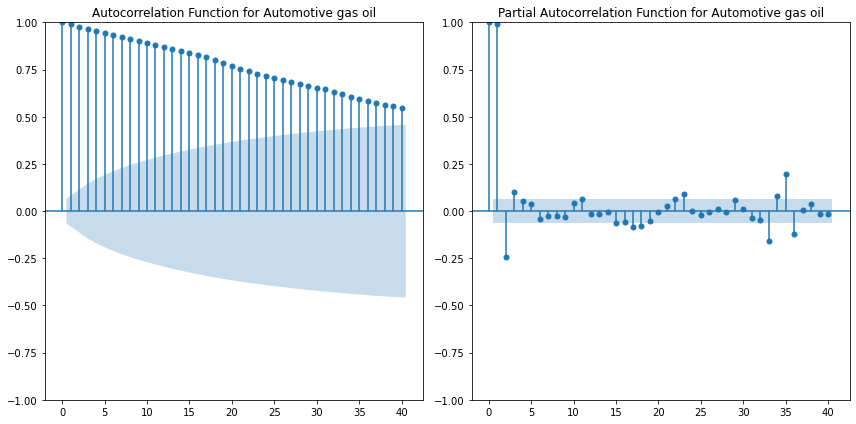

ACF and PACF for Euro-Super 95:


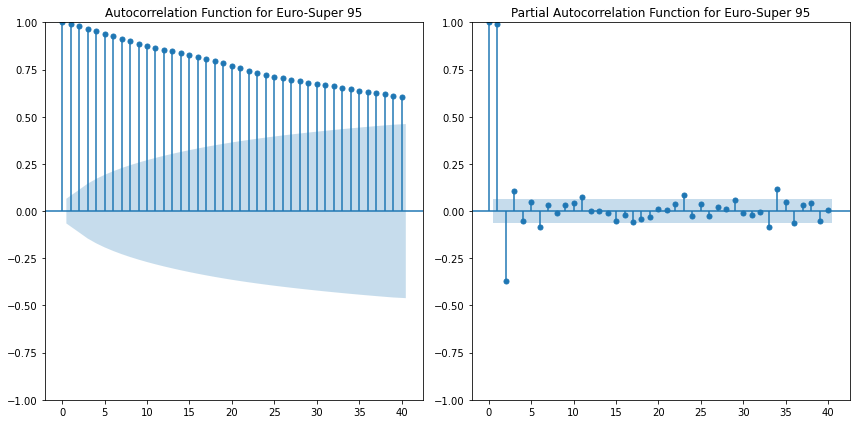

ACF and PACF for Heating gas oil:


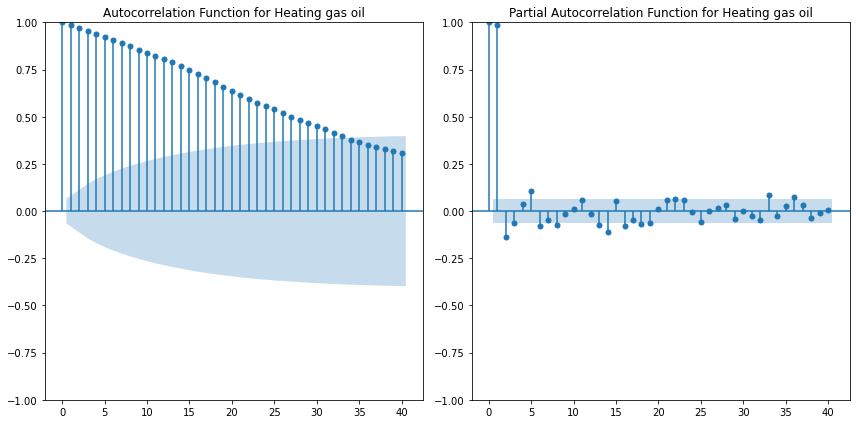

ACF and PACF for Heavy fuel oil:


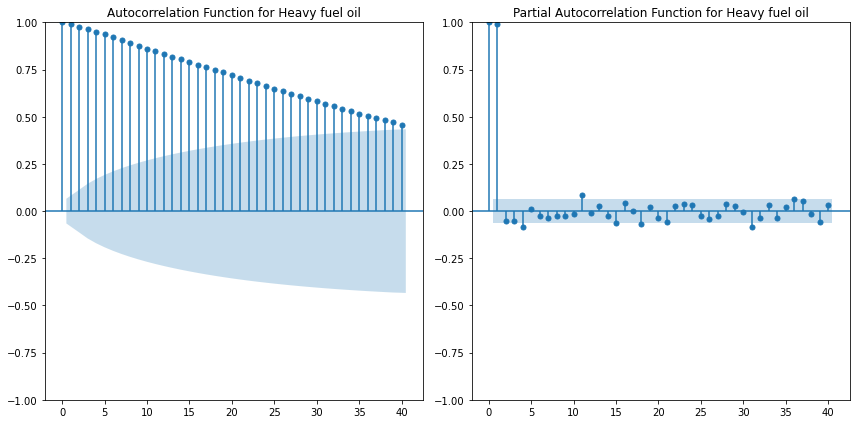

ACF and PACF for LPG:


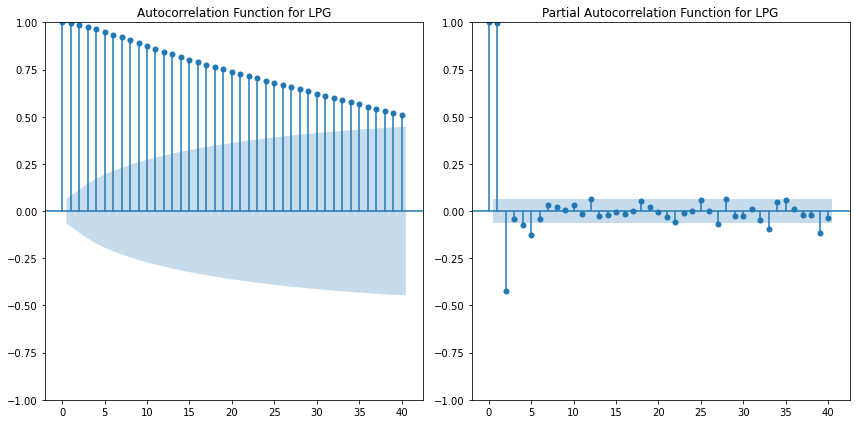

ACF and PACF for Residual fuel oil:


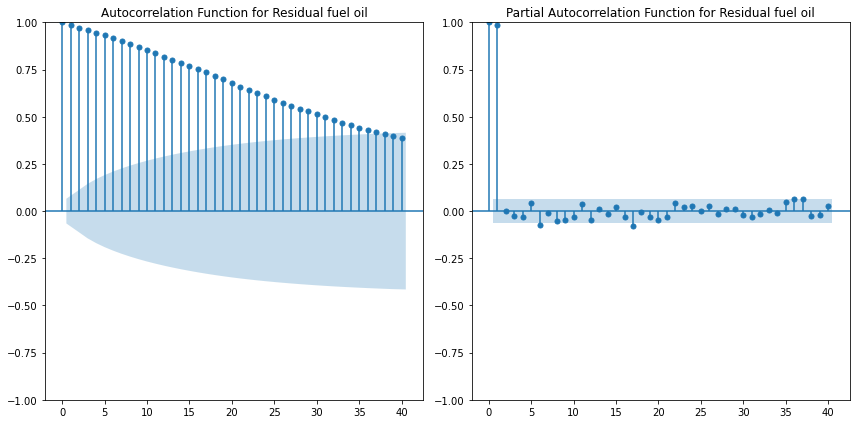

In [98]:
#Plot the anitial ACF and PACF for each fuel type

# Pivot the data
df_pivot = df.pivot_table(index='SURVEY_DATE', columns='PRODUCT_NAME', values='PRICE')

# Calculate and plot ACF and PACF for each fuel type
for fuel_type in df_pivot.columns:
    print(f'ACF and PACF for {fuel_type}:')
    y = df_pivot[fuel_type].dropna()
    
    # Calculate ACF and PACF
    lag_acf = acf(y, nlags=40)
    lag_pacf = pacf(y, nlags=40, method='ols')

    # Plot ACF
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(y, lags=40, ax=plt.gca())
    plt.title(f'Autocorrelation Function for {fuel_type}')

    # Plot PACF
    plt.subplot(122)
    plot_pacf(y, lags=40, ax=plt.gca())
    plt.title(f'Partial Autocorrelation Function for {fuel_type}')

    plt.tight_layout()
    plt.show()

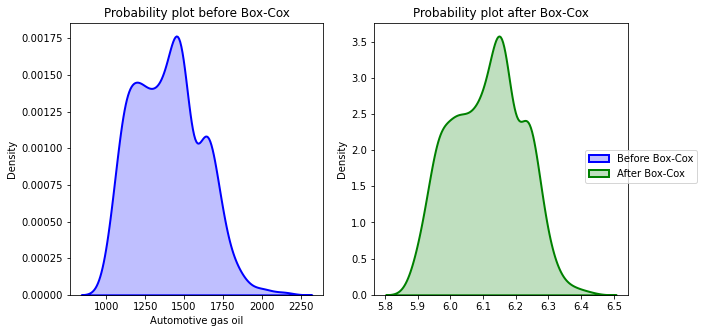

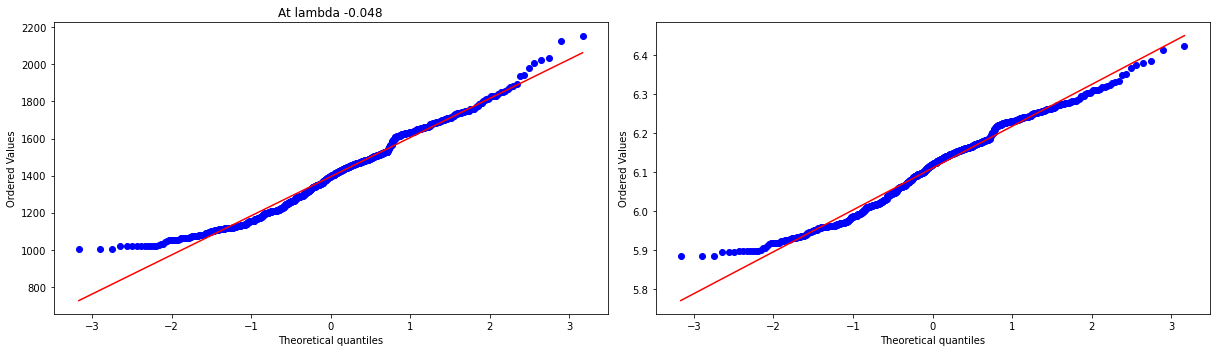

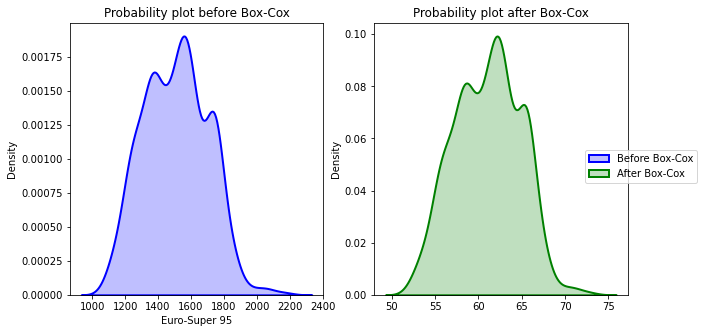

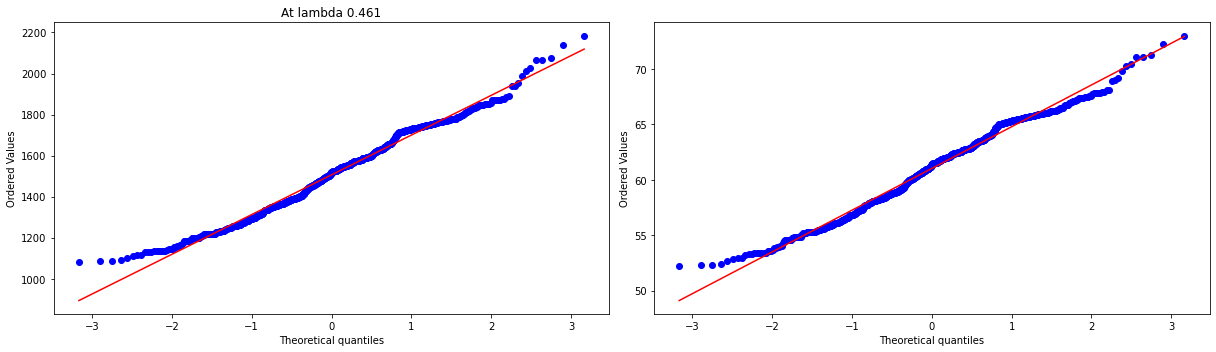

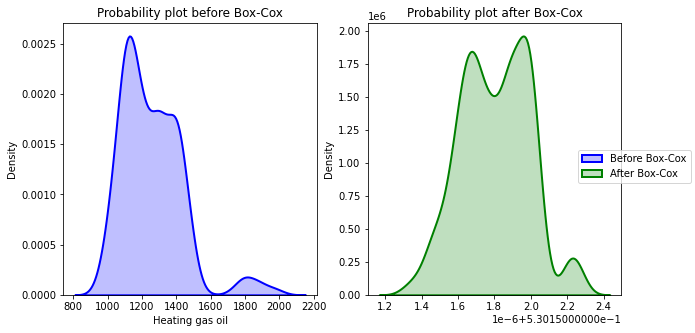

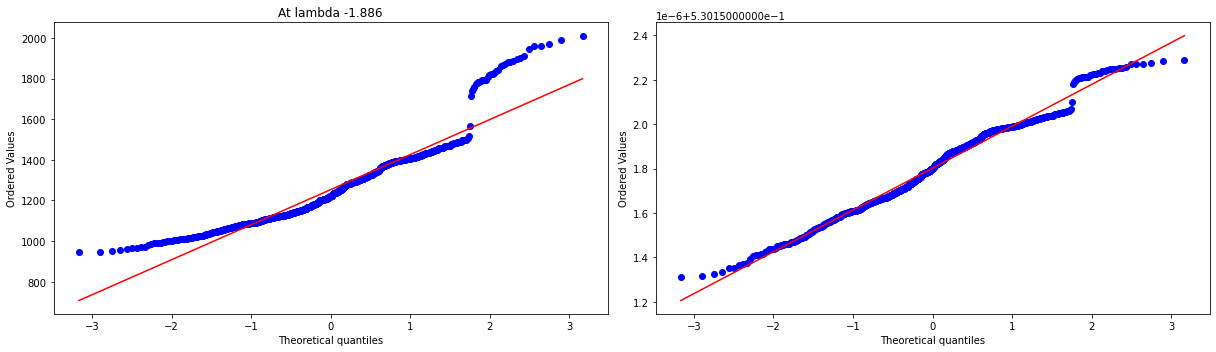

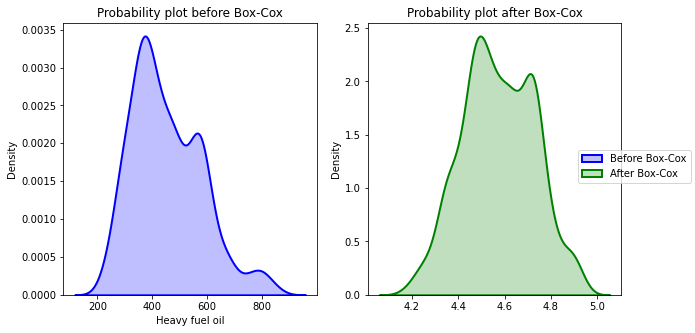

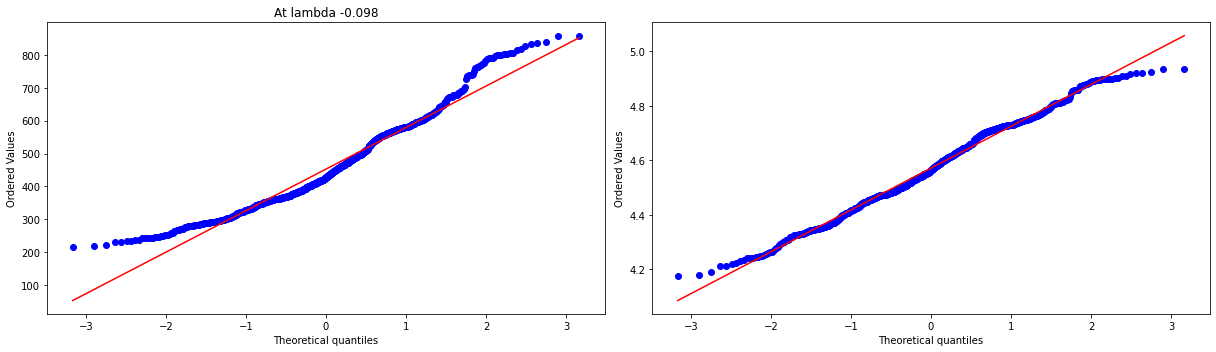

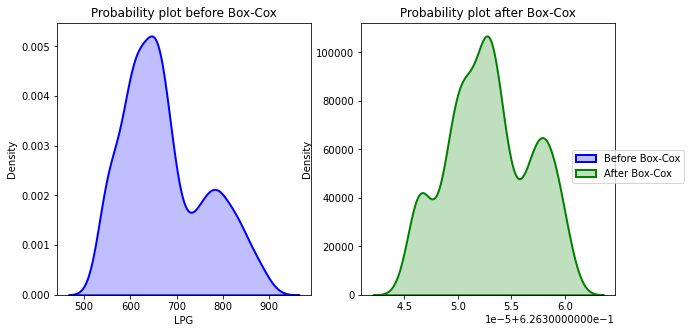

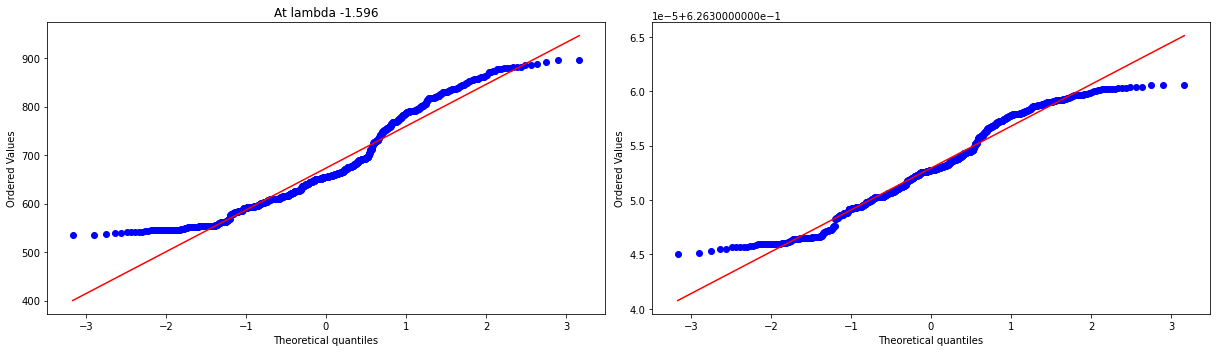

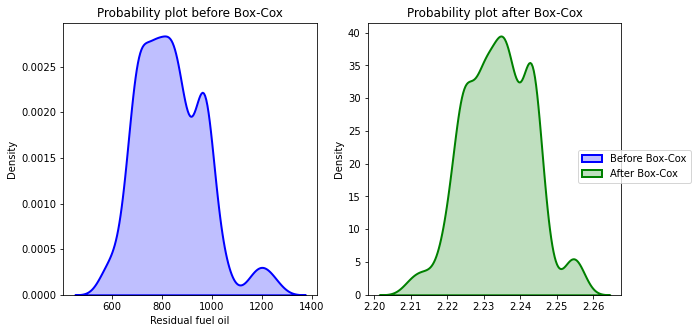

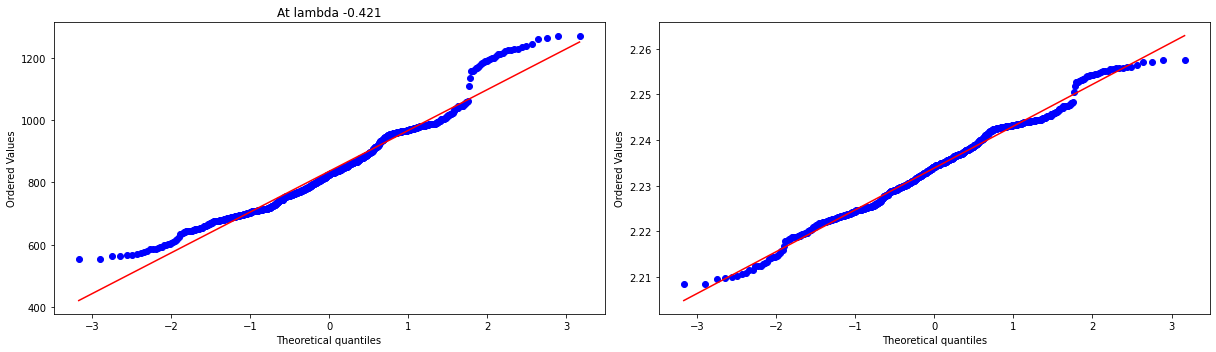

In [99]:
#Our AGO price is clearly non statationary as we can se an upward trend in price. The level and
#Variability both increasing with time hence, we can surely said there is a large seasonal component
#with period of 12.

#We then transform the data into a stationary type using multiple methods

#Method 1: Box-Cox Transformations

def boxcox_decompose(ts, graph_title=""):
    decomposition, lam = boxcox(ts) 
    # Create a stationary time series by obtaining our residuals from classical decompostion
    stationary_ts = decomposition

    # Plot the original time series and its components
    fig, ax = plt.subplots(1, 2)
    sns.distplot(ts, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Before Box-Cox", color ="blue", ax = ax[0])
    sns.distplot(stationary_ts, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "After Box-Cox", color ="green", ax = ax[1])
    fig.legend(loc = "center right")
    ax[0].set(title="Probability plot before Box-Cox")
    ax[1].set(title="Probability plot after Box-Cox")
    fig.set_figheight(5)
    fig.set_figwidth(10)
    
    fig, ax = plt.subplots(1, 2)
    prob = stats.probplot(ts, dist=stats.norm, plot=ax[0])
    title="At lambda "
    title+= str(round(lam,3))
    ax[0].set(title=title)
    prob = stats.probplot(stationary_ts, dist=stats.norm, plot=ax[1])
    ax[1].set(title="")

    fig.set_figheight(5)
    fig.set_figwidth(17)

    plt.tight_layout()

    return stationary_ts

# Perform classical decomposition and create a stationary time series for each fuel type
stationary_boxcox_dict = {}
for fuel_type in df_pivot.columns:
    #print(f'Box-Cox Decomposition for {fuel_type}:')
    gtitle = "Box-Cox Decomposition for "
    gtitle += fuel_type
    y = df_pivot[fuel_type].dropna()
    stationary_boxcox_ts = boxcox_decompose(y,gtitle)
    stationary_boxcox_dict[fuel_type] = stationary_boxcox_ts

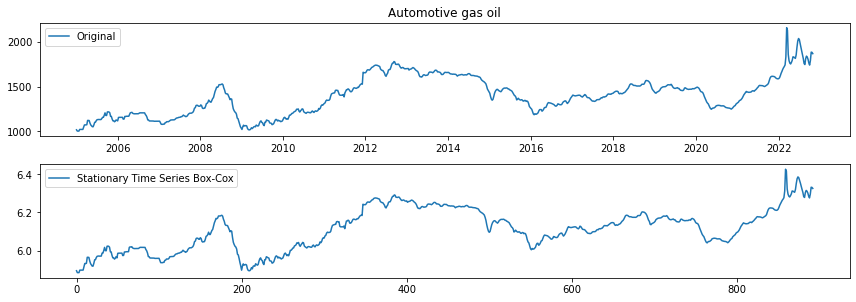

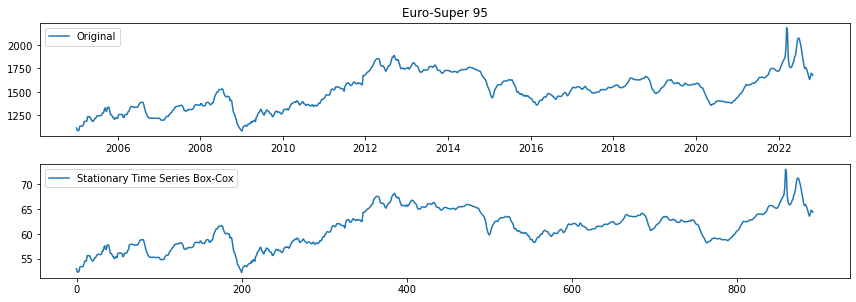

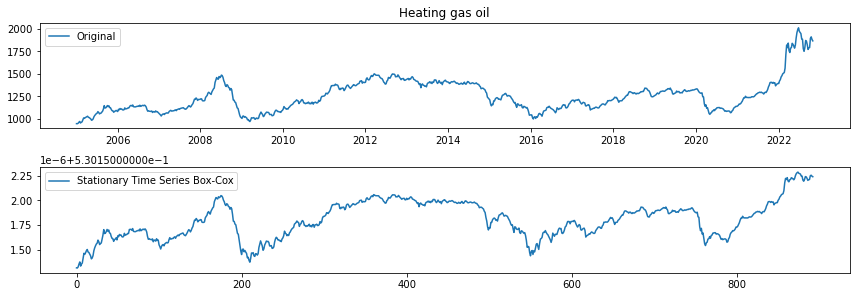

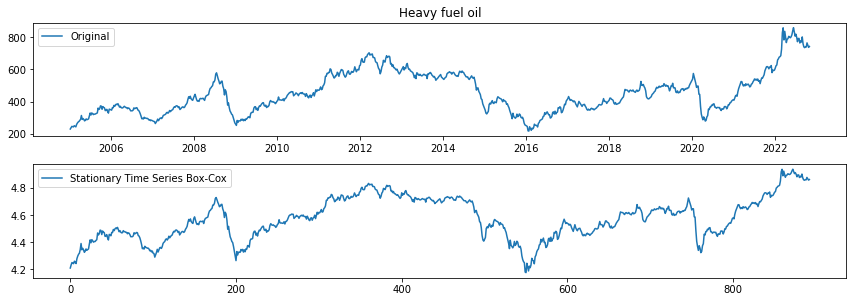

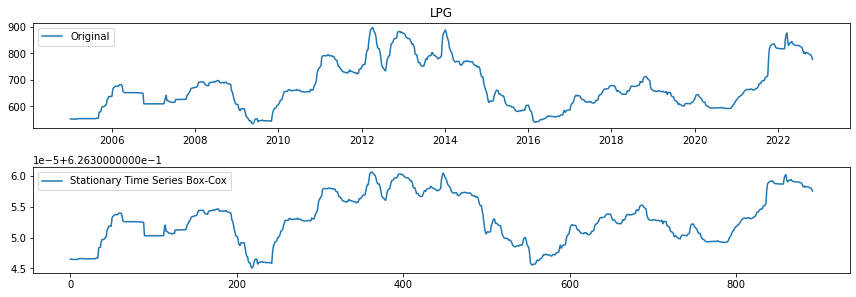

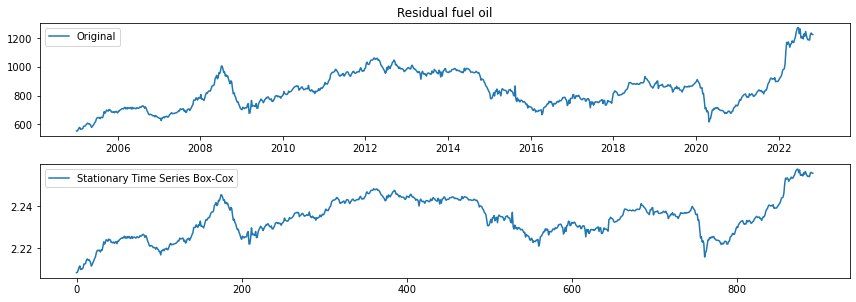

In [100]:
# Plot the original time series Box-Cox time series
    
for fuel_type in df_pivot.columns:
    y = df_pivot[fuel_type].dropna()
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(y, label='Original')
    plt.title(fuel_type)
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(stationary_boxcox_dict[fuel_type], label='Stationary Time Series Box-Cox')
    plt.legend(loc='upper left')
    plt.tight_layout()
    # Plot the stationary time series    
    plt.show()
    

Box-Cox ACF and PACF for Automotive gas oil:


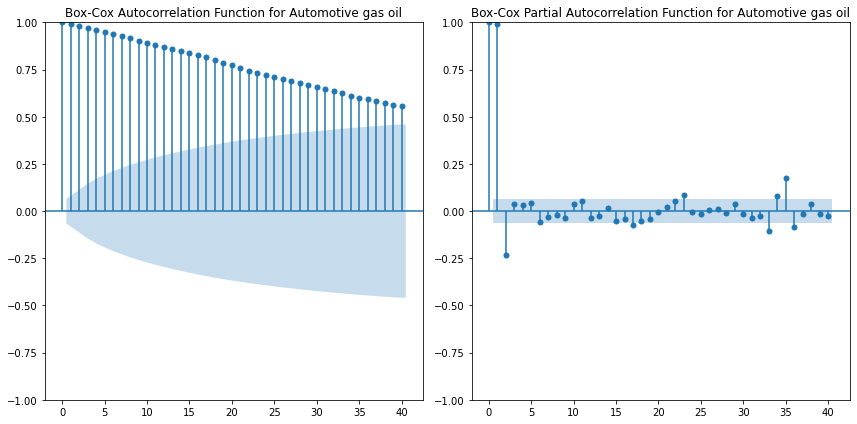

Box-Cox ACF and PACF for Euro-Super 95:


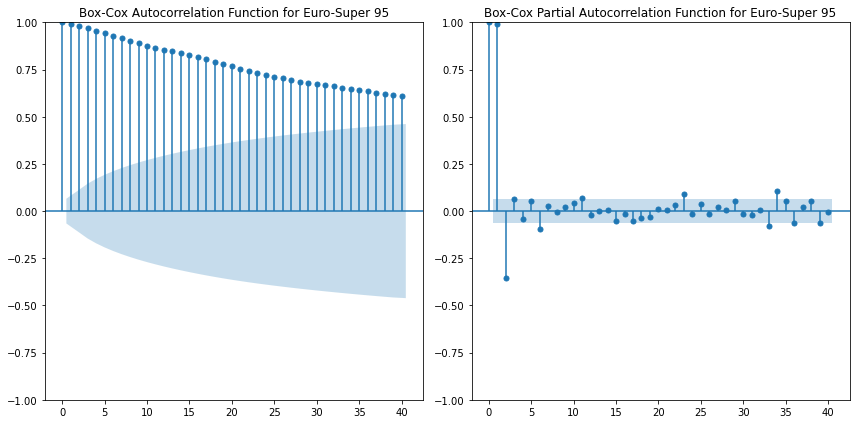

Box-Cox ACF and PACF for Heating gas oil:


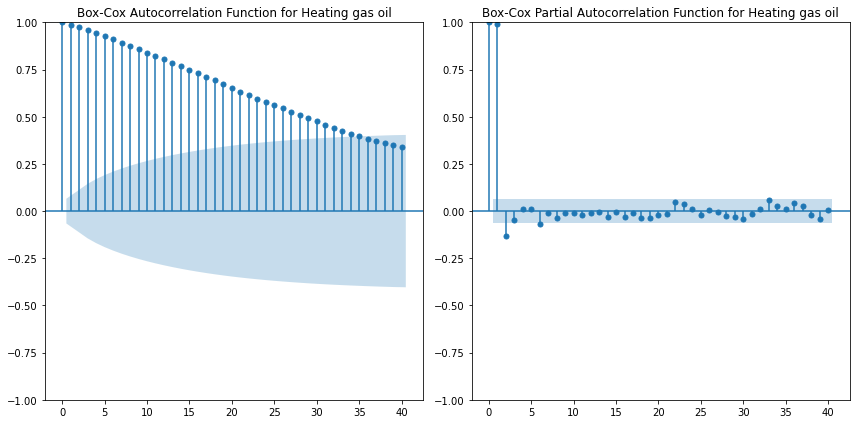

Box-Cox ACF and PACF for Heavy fuel oil:


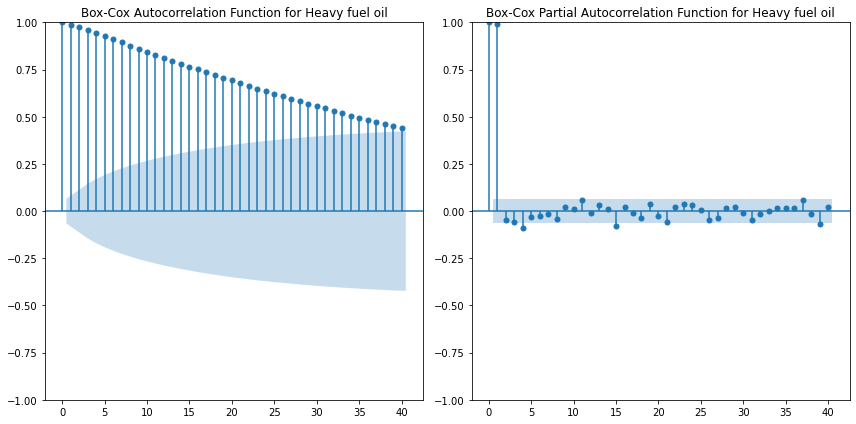

Box-Cox ACF and PACF for LPG:


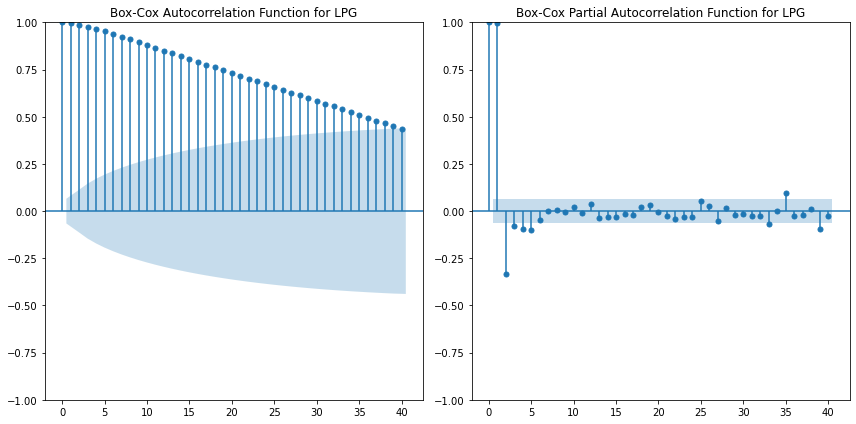

Box-Cox ACF and PACF for Residual fuel oil:


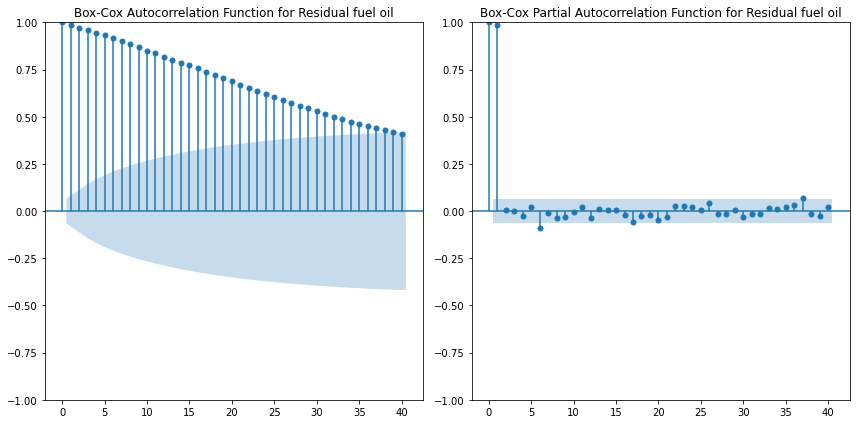

In [101]:
#Plot the Box-Cox time-series ACF and PACF
import warnings
warnings.filterwarnings('ignore')#Supress warning

for fuel_type in stationary_boxcox_dict:
    print(f'Box-Cox ACF and PACF for {fuel_type}:')
    y = stationary_boxcox_dict[fuel_type]
    
    # Calculate ACF and PACF
    lag_acf = acf(y, nlags=40), 
    lag_pacf = pacf(y, nlags=40, method='ols')

    # Plot ACF
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(y, lags=40, ax=plt.gca())
    plt.title(f'Box-Cox Autocorrelation Function for {fuel_type}')

    # Plot PACF
    plt.subplot(122)
    plot_pacf(y, lags=40, ax=plt.gca())
    plt.title(f'Box-Cox Partial Autocorrelation Function for {fuel_type}')

    plt.tight_layout()
    plt.show()

Seasonal decomposition and stationarization for Automotive gas oil:


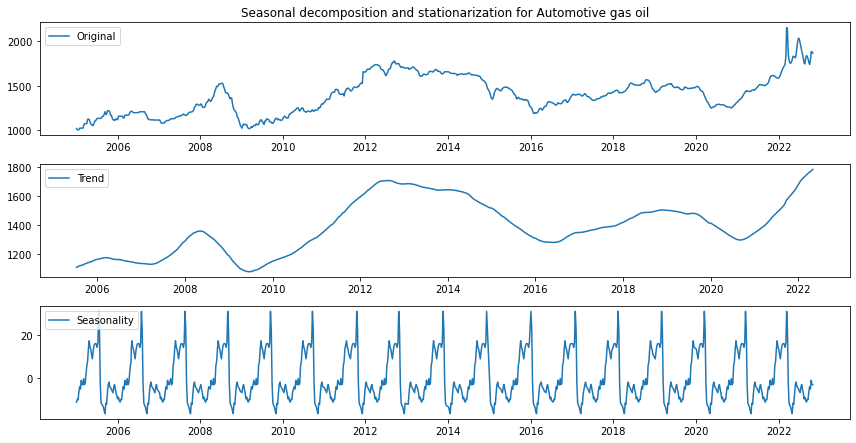

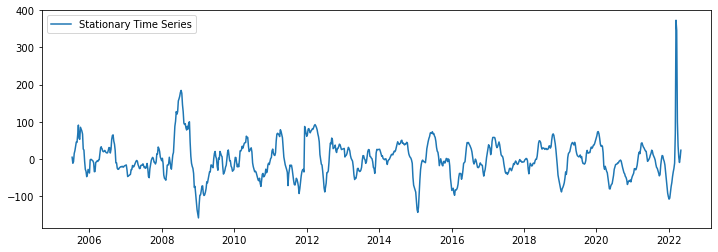

Seasonal decomposition and stationarization for Euro-Super 95:


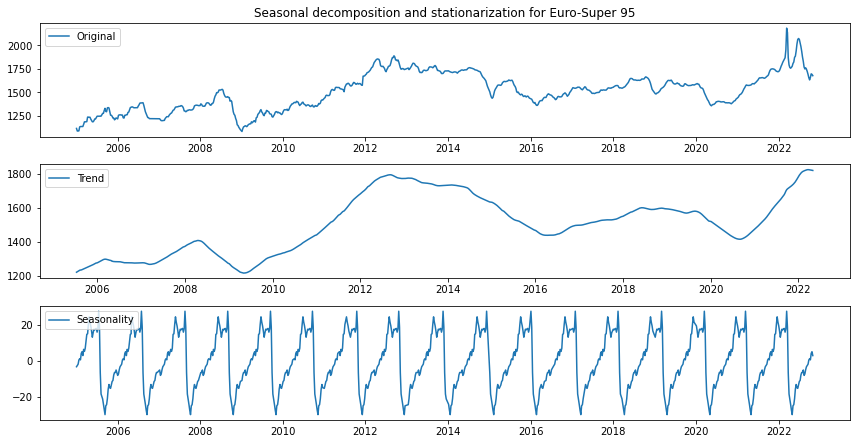

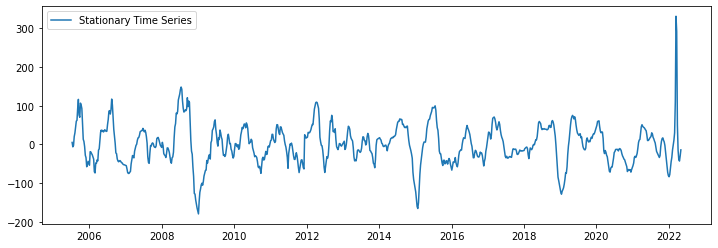

Seasonal decomposition and stationarization for Heating gas oil:


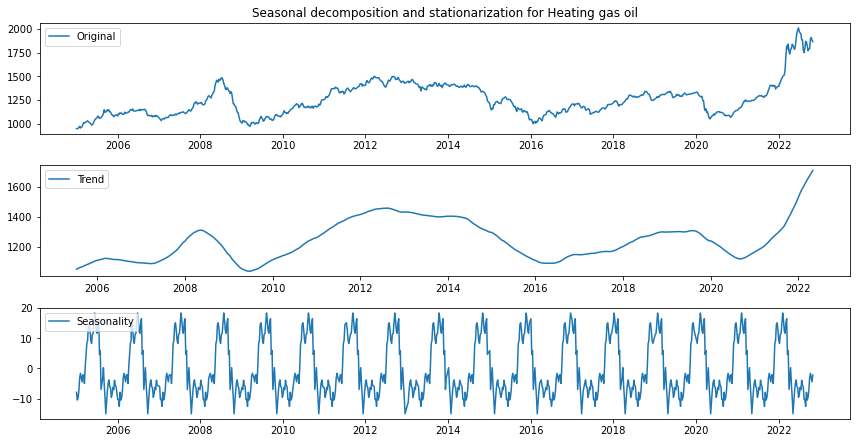

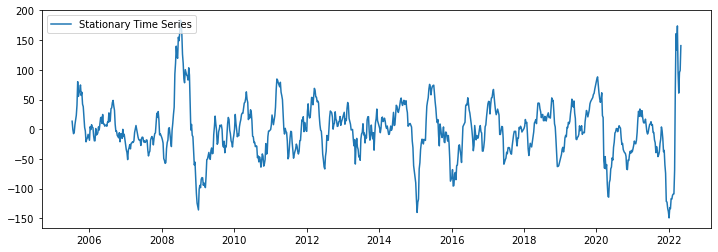

Seasonal decomposition and stationarization for Heavy fuel oil:


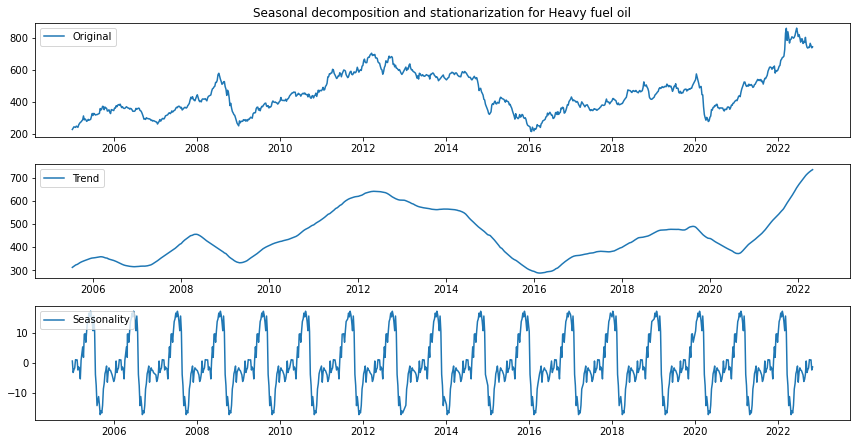

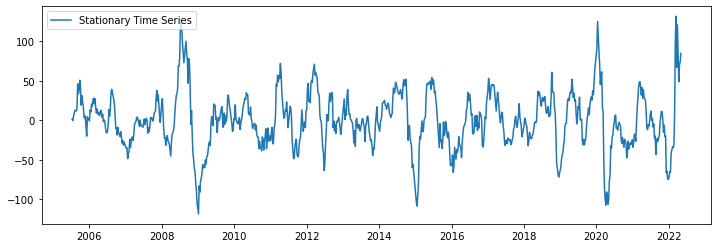

Seasonal decomposition and stationarization for LPG:


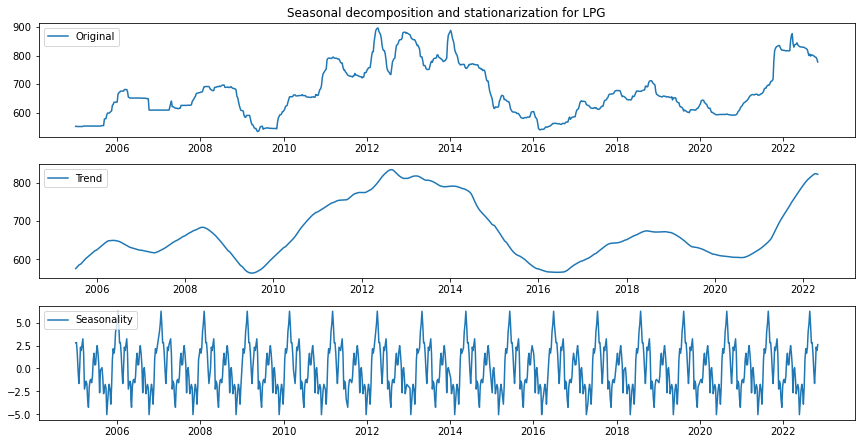

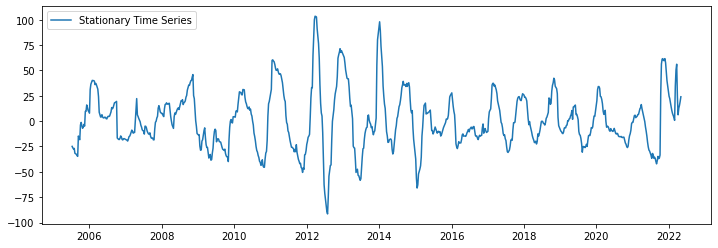

Seasonal decomposition and stationarization for Residual fuel oil:


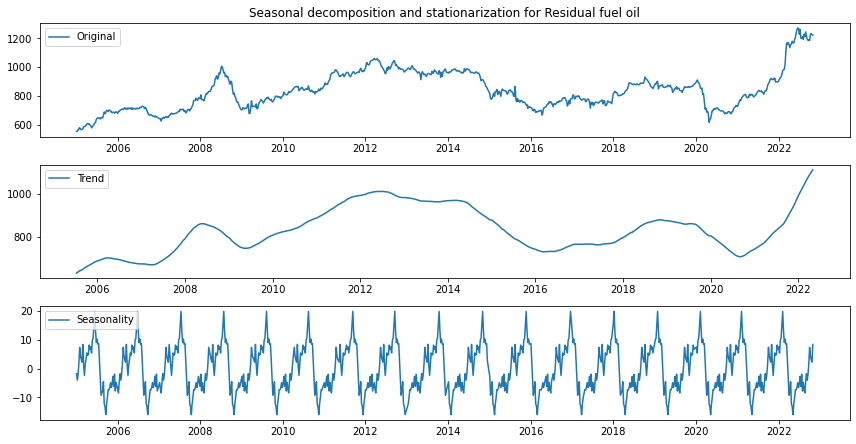

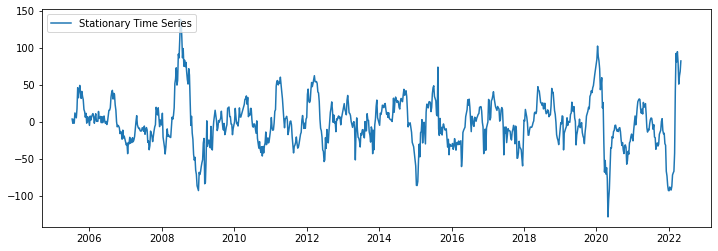

In [102]:
def classical_decompose(ts, graph_title="",period=52): #Period =52 represents assumption of yearly seasonality
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(ts, period=period, model='additive') #Classical decomposition using linear/quadratic

    # Extract components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Create a stationary time series by obtaining our residuals from classical decompostion
    stationary_ts = residual

    # Plot the original time series and its components
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.title(graph_title)
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='upper left')
    plt.tight_layout()

    # Plot the stationary time series
    plt.figure(figsize=(12, 4))
    plt.plot(stationary_ts, label='Stationary Time Series')
    plt.legend(loc='upper left')
    plt.show()

    return stationary_ts

# Perform classical decomposition and create a stationary time series for each fuel type
stationary_ts_dict = {}
for fuel_type in df_pivot.columns:
    print(f'Seasonal decomposition and stationarization for {fuel_type}:')
    gtitle = "Seasonal decomposition and stationarization for "
    gtitle += fuel_type
    y = df_pivot[fuel_type].dropna()
    stationary_ts = classical_decompose(y,gtitle)
    stationary_ts_dict[fuel_type] = stationary_ts

ACF and PACF for Automotive gas oil:


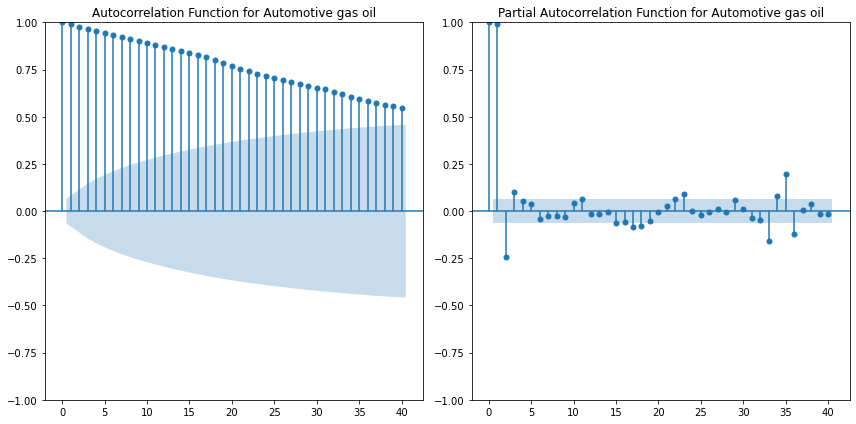

ACF and PACF for Euro-Super 95:


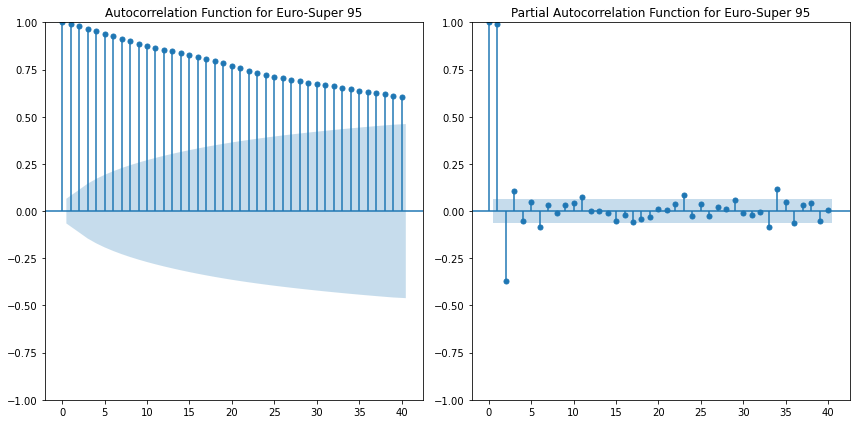

ACF and PACF for Heating gas oil:


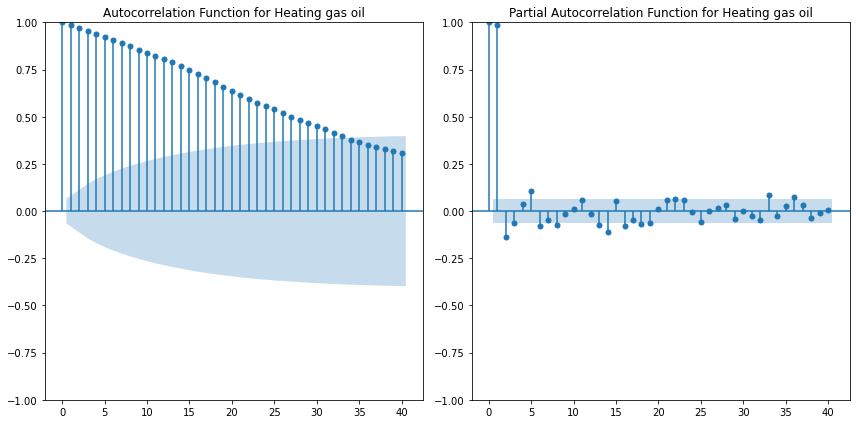

ACF and PACF for Heavy fuel oil:


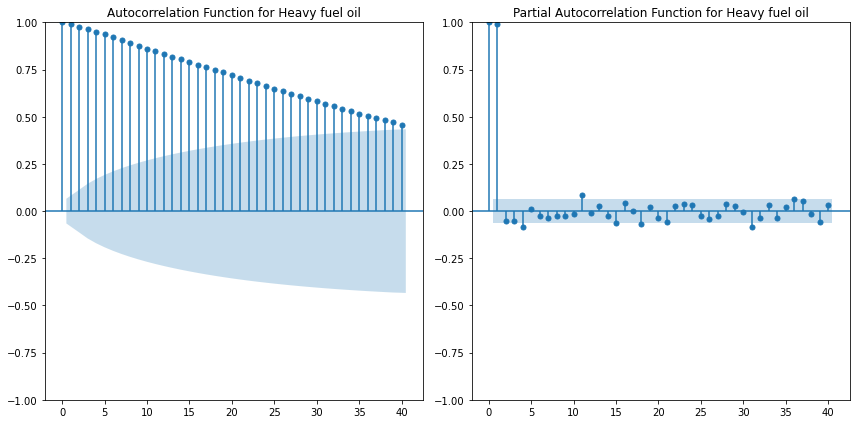

ACF and PACF for LPG:


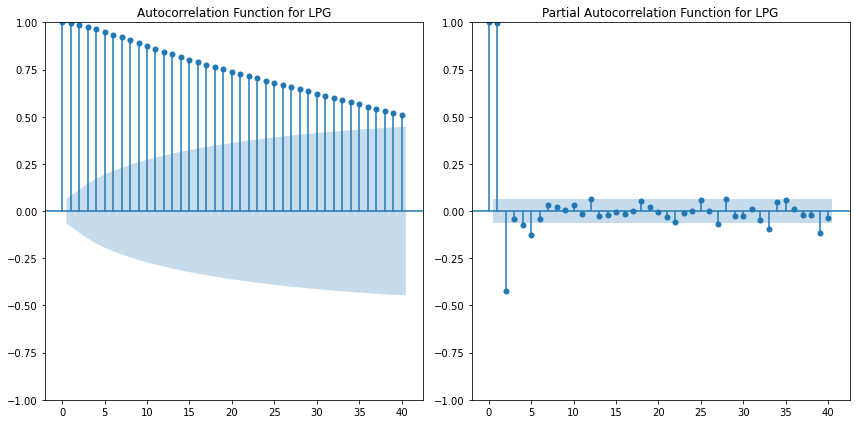

ACF and PACF for Residual fuel oil:


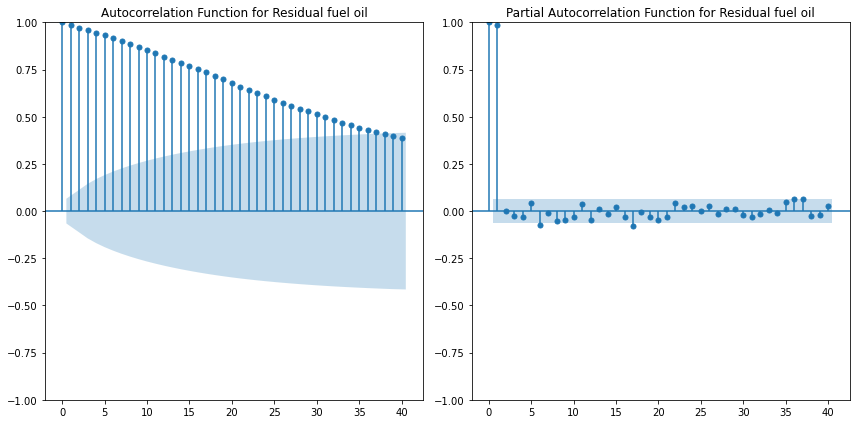

In [103]:
#Plot the classical time-series ACF and PACF
import warnings
warnings.filterwarnings('ignore')#Supress warning

for fuel_type in stationary_ts_dict:
    print(f'ACF and PACF for {fuel_type}:')
    y = df_pivot[fuel_type].dropna()
    
    # Calculate ACF and PACF
    lag_acf = acf(y, nlags=40), 
    lag_pacf = pacf(y, nlags=40, method='ols')

    # Plot ACF
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(y, lags=40, ax=plt.gca())
    plt.title(f'Autocorrelation Function for {fuel_type}')

    # Plot PACF
    plt.subplot(122)
    plot_pacf(y, lags=40, ax=plt.gca())
    plt.title(f'Partial Autocorrelation Function for {fuel_type}')

    plt.tight_layout()
    plt.show()